In [28]:
%matplotlib inline
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
token = user_secrets.get_secret("GITHUB_TOKEN")

print("Token loaded. First 5 chars:", token[:5], "...")

Token loaded. First 5 chars: ghp_q ...


In [20]:
!pip install ace-tools

In [21]:
# Clone git repository 
!git clone https://{token}@github.com/KangyuZHAO/Artificial-Intellengence-Frontier-Homework.git
%cd Artificial-Intellengence-Frontier-Homework/EECS_E6895_FINALPROJECT_SKETCH  
# /kaggle/working/Artificial-Intellengence-Frontier-Homework

Cloning into 'Artificial-Intellengence-Frontier-Homework'...
remote: Enumerating objects: 3519, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 3519 (delta 20), reused 3 (delta 1), pack-reused 3482 (from 2)
Receiving objects: 100% (3519/3519), 68.44 MiB | 36.92 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/kaggle/working/Artificial-Intellengence-Frontier-Homework/EECS_E6895_FINALPROJECT_SKETCH/Artificial-Intellengence-Frontier-Homework/EECS_E6895_FINALPROJECT_SKETCH/Artificial-Intellengence-Frontier-Homework/EECS_E6895_FINALPROJECT_SKETCH


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


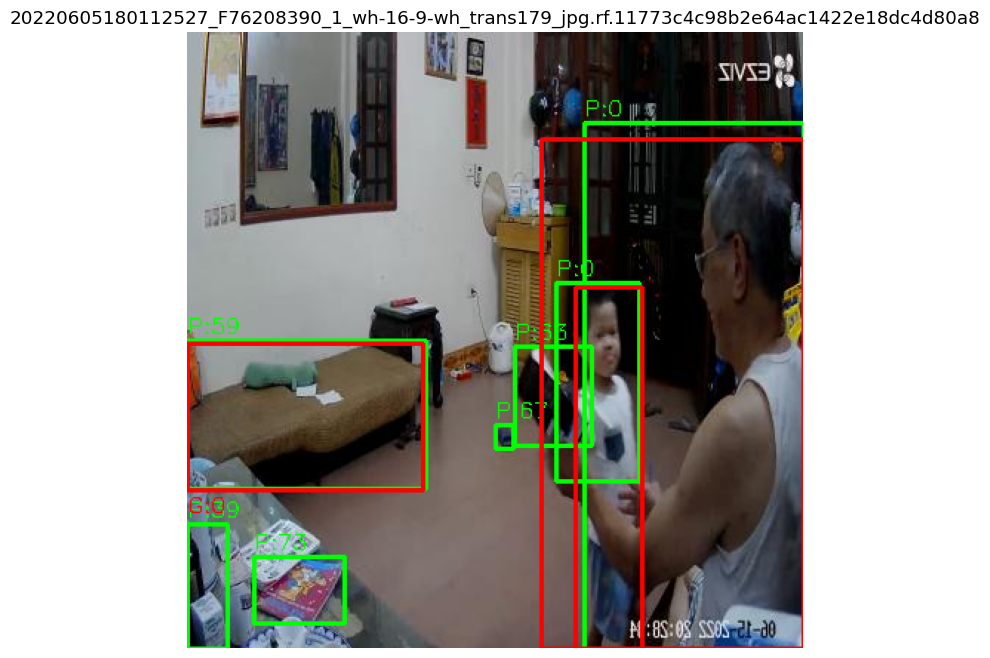

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


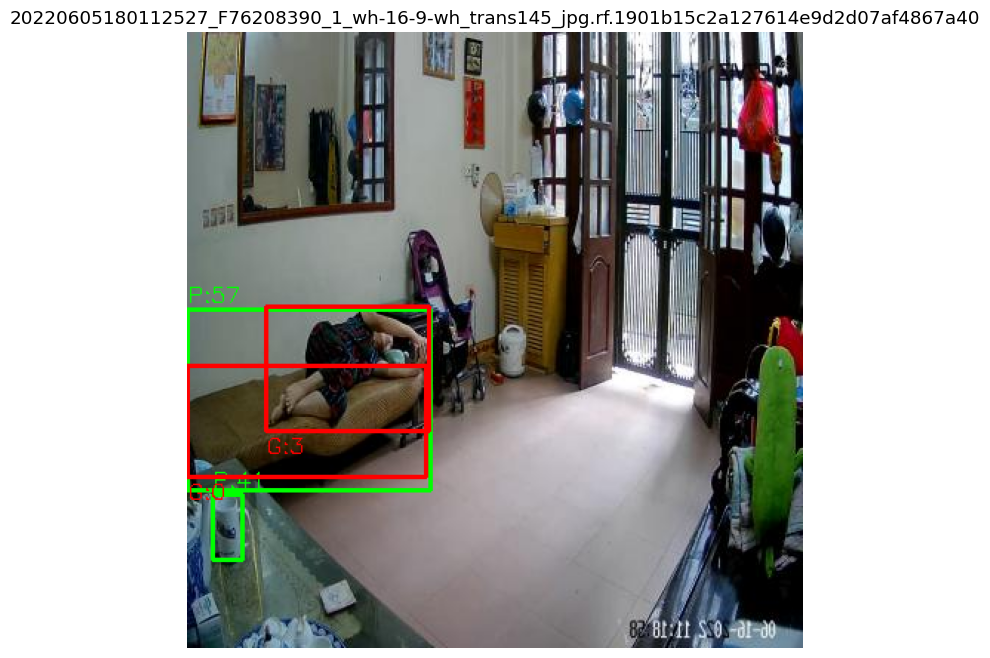

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


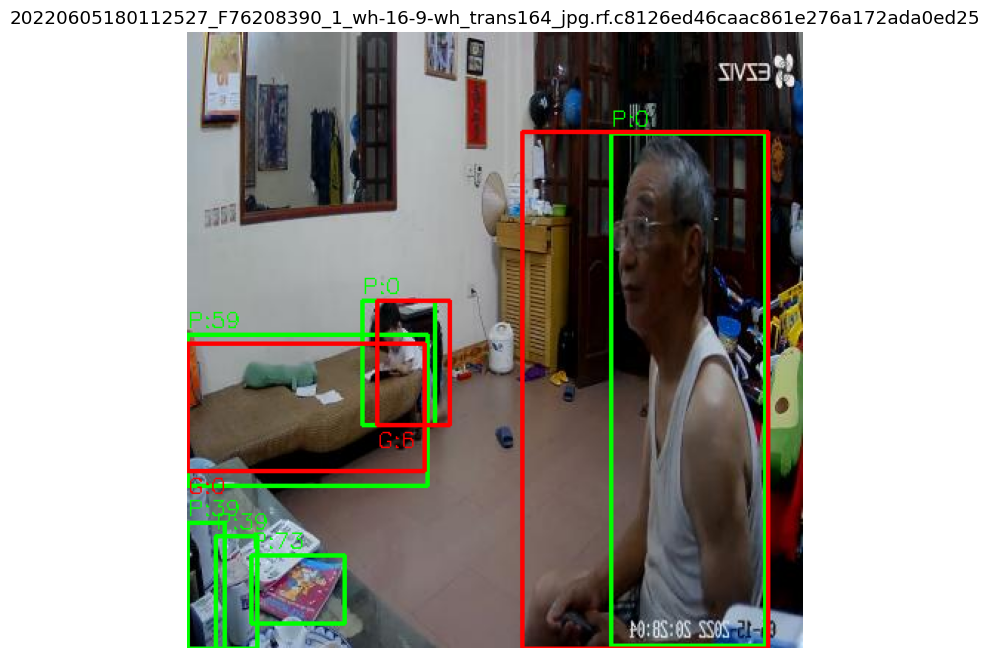

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


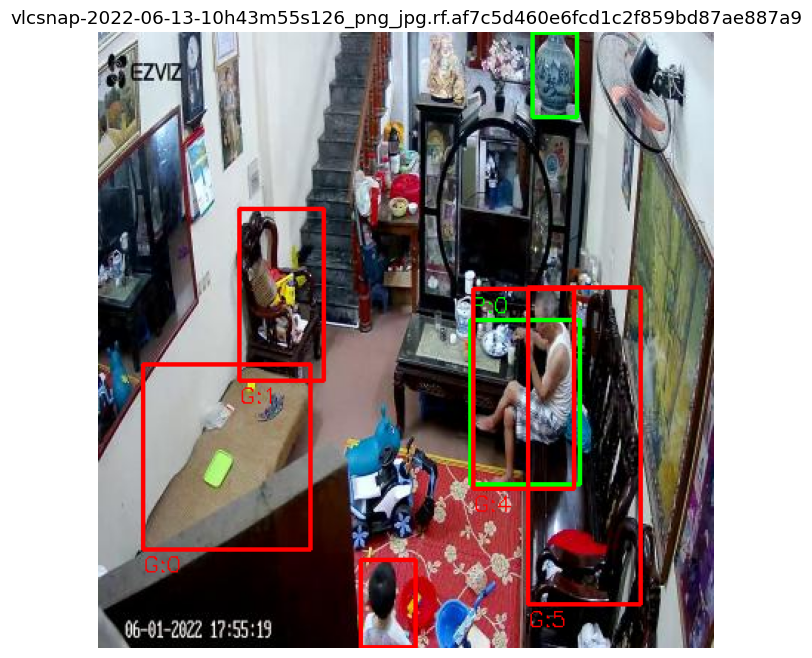

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


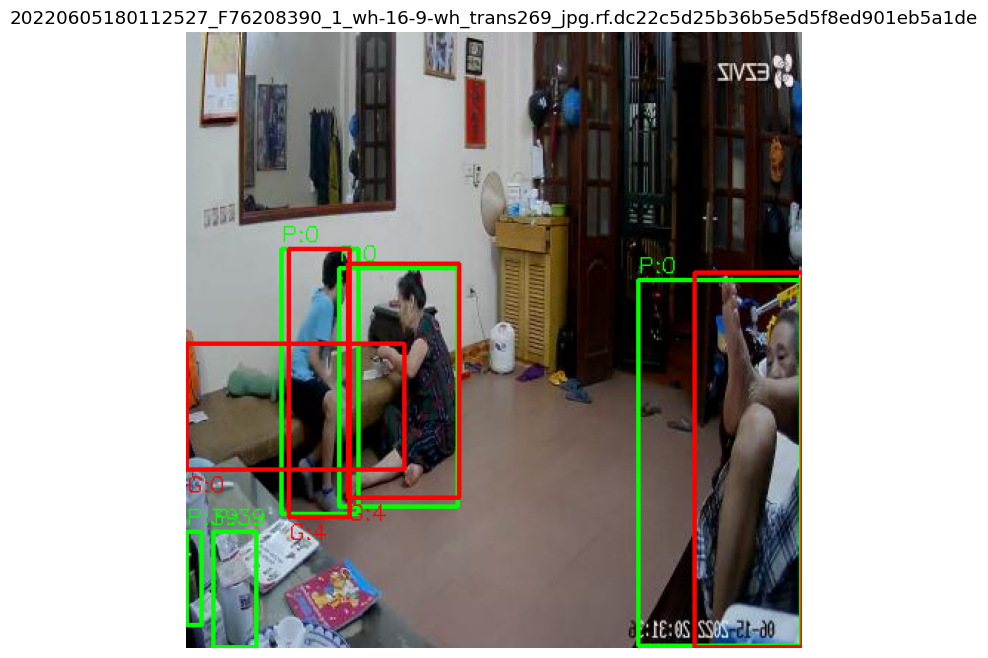

                                               Image  mAP_50:95
0  20220605180112527_F76208390_1_wh-16-9-wh_trans...        0.0
1  20220605180112527_F76208390_1_wh-16-9-wh_trans...        0.0
2  20220605180112527_F76208390_1_wh-16-9-wh_trans...        0.0
3  vlcsnap-2022-06-13-10h43m55s126_png_jpg.rf.af7...        0.0
4  20220605180112527_F76208390_1_wh-16-9-wh_trans...        0.0

Average mAP@[.50:.95]: 0.0000


In [22]:
from pathlib import Path
import os
import json
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from image_parsor import model, calculate_iou

# Set paths
IMAGE_DIR = Path("./data/train/images")
LABEL_DIR = Path("./data/train/labels")
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


# ---------------- Module 1: Dataset Sampler ----------------
class YoloDatasetSampler:
    def __init__(self, image_dir, label_dir, num_samples=5):
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.num_samples = num_samples

    def sample(self):
        all_images = list(self.image_dir.glob("*.jpg"))
        sampled = random.sample(all_images, min(self.num_samples, len(all_images)))
        return sampled


# ---------------- Module 2: Ground Truth Loader ----------------
def read_yolo_label(txt_path, img_width, img_height):
    labels = []
    with open(txt_path, "r") as f:
        for line in f:
            cls, cx, cy, w, h = map(float, line.strip().split())
            xmin = (cx - w / 2) * img_width
            xmax = (cx + w / 2) * img_width
            ymin = (cy - h / 2) * img_height
            ymax = (cy + h / 2) * img_height
            labels.append({
                "class": int(cls),
                "bbox": [xmin, ymin, xmax, ymax]
            })
    return labels


# ---------------- Module 3: Visualizer ----------------
def visualize_prediction(image_np, preds, gts, title=""):
    img = image_np.copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Draw predictions (green)
    for p in preds:
        x1, y1, x2, y2 = map(int, p['bbox'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"P:{p['class']}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Draw ground truths (red)
    for g in gts:
        x1, y1, x2, y2 = map(int, g['bbox'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, f"G:{g['class']}", (x1, y2 + 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


# ---------------- Module 4: Evaluator ----------------
class MAPEvaluator:
    def __init__(self, iou_thresholds=np.linspace(0.5, 0.95, 10)):
        self.iou_thresholds = iou_thresholds

    def evaluate_image(self, preds, gts):
        ap_scores = []
        for iou_thresh in self.iou_thresholds:
            matched = 0
            for gt in gts:
                gt_box = gt['bbox']
                gt_cls = gt['class']
                for pred in preds:
                    if pred['class'] != gt_cls:
                        continue
                    iou = calculate_iou(gt_box, pred['bbox'])
                    if iou >= iou_thresh:
                        matched += 1
                        break
            precision = matched / max(len(preds), 1)
            ap_scores.append(precision)
        return float(np.mean(ap_scores)) if ap_scores else 0.0

    def evaluate_dataset(self, pred_dict, gt_dict):
        scores = {}
        for img_name in pred_dict:
            scores[img_name] = self.evaluate_image(pred_dict[img_name], gt_dict.get(img_name, []))
        return scores


# ---------------- Pipeline Controller ----------------
def run_pipeline(image_dir, label_dir, output_dir, num_samples=5, visualize=True):
    sampler = YoloDatasetSampler(image_dir, label_dir, num_samples)
    images = sampler.sample()

    pred_dict = {}
    gt_dict = {}

    for img_path in images:
        img_name = img_path.stem
        label_path = label_dir / f"{img_name}.txt"

        image = np.array(Image.open(img_path).convert("RGB"))
        h, w = image.shape[:2]
        results = model(image)
        detections = results.pandas().xyxy[0]

        preds = [{
            "class": int(row['class']),
            "confidence": float(row['confidence']),
            "bbox": [float(row['xmin']), float(row['ymin']), float(row['xmax']), float(row['ymax'])]
        } for _, row in detections.iterrows()]
        pred_dict[img_name] = preds

        gts = read_yolo_label(label_path, w, h) if label_path.exists() else []
        gt_dict[img_name] = gts

        if visualize:
            visualize_prediction(image, preds, gts, title=img_name)

    # Save intermediate JSONs
    with open(output_dir / "detection_results.json", "w") as f:
        json.dump(pred_dict, f, indent=2)
    with open(output_dir / "ground_truths.json", "w") as f:
        json.dump(gt_dict, f, indent=2)

    # Evaluate
    evaluator = MAPEvaluator()
    scores = evaluator.evaluate_dataset(pred_dict, gt_dict)
    result = {
        "MAP_results": scores,
        "MAP_average": float(np.mean(list(scores.values())))
    }
    with open(output_dir / "metrics_results.json", "w") as f:
        json.dump(result, f, indent=2)

    return result


# Run the pipeline for 5 samples with visualization
final_result = run_pipeline(IMAGE_DIR, LABEL_DIR, OUTPUT_DIR, num_samples=5, visualize=True)
df = pd.DataFrame(final_result["MAP_results"].items(), columns=["Image", "mAP_50:95"])
print(df)
print(f"\nAverage mAP@[.50:.95]: {final_result['MAP_average']:.4f}")


In [23]:
with open(OUTPUT_DIR / "detection_results.json", "r") as f:
    data = json.load(f)

data

{'20220605180112527_F76208390_1_wh-16-9-wh_trans179_jpg.rf.11773c4c98b2e64ac1422e18dc4d80a8': [{'class': 59,
   'confidence': 0.5777488350868225,
   'bbox': [0.18521270155906677,
    208.9097137451172,
    161.67237854003906,
    308.6440734863281]},
  {'class': 67,
   'confidence': 0.5190420746803284,
   'bbox': [208.35824584960938,
    265.0148010253906,
    220.84634399414062,
    281.9385986328125]},
  {'class': 63,
   'confidence': 0.5104568004608154,
   'bbox': [221.5813446044922,
    212.5431671142578,
    273.2528381347656,
    279.6207580566406]},
  {'class': 0,
   'confidence': 0.4972390830516815,
   'bbox': [268.5794372558594, 61.72030258178711, 416.0, 416.0]},
  {'class': 39,
   'confidence': 0.49294424057006836,
   'bbox': [0.0, 332.0853576660156, 27.303281784057617, 416.0]},
  {'class': 0,
   'confidence': 0.40459713339805603,
   'bbox': [249.5501251220703,
    169.84617614746094,
    305.40216064453125,
    303.70306396484375]},
  {'class': 73,
   'confidence': 0.2798856

In [24]:
with open(OUTPUT_DIR / "ground_truths.json", "r") as f:
    data = json.load(f)

data

{'20220605180112527_F76208390_1_wh-16-9-wh_trans179_jpg.rf.11773c4c98b2e64ac1422e18dc4d80a8': [{'class': 4,
   'bbox': [239.00000000000003, 72.00000000000003, 416.0, 416.0]},
  {'class': 0, 'bbox': [0.2499999999999991, 210.5, 159.75000000000003, 309.5]},
  {'class': 6, 'bbox': [262.0, 172.0, 307.0, 416.0]}],
 '20220605180112527_F76208390_1_wh-16-9-wh_trans145_jpg.rf.1901b15c2a127614e9d2d07af4867a40': [{'class': 3,
   'bbox': [53.75000000000001, 185.75, 163.25, 269.25]},
  {'class': 0, 'bbox': [0.0, 225.00000000000003, 161.0, 300.0]}],
 '20220605180112527_F76208390_1_wh-16-9-wh_trans164_jpg.rf.c8126ed46caac861e276a172ada0ed25': [{'class': 6,
   'bbox': [128.5, 181.25, 177.50000000000003, 265.75]},
  {'class': 4, 'bbox': [226.00000000000003, 67.0, 392.0, 416.0]},
  {'class': 0, 'bbox': [0.0, 210.5, 160.0, 296.5]}],
 'vlcsnap-2022-06-13-10h43m55s126_png_jpg.rf.af7c5d460e6fcd1c2f859bd87ae887a9': [{'class': 1,
   'bbox': [95.0, 119.74999999999997, 152.0, 235.25]},
  {'class': 4,
   'bbox': 

In [25]:
with open(OUTPUT_DIR / "metrics_results.json", "r") as f:
    data = json.load(f)

data

{'MAP_results': {'20220605180112527_F76208390_1_wh-16-9-wh_trans179_jpg.rf.11773c4c98b2e64ac1422e18dc4d80a8': 0.0,
  '20220605180112527_F76208390_1_wh-16-9-wh_trans145_jpg.rf.1901b15c2a127614e9d2d07af4867a40': 0.0,
  '20220605180112527_F76208390_1_wh-16-9-wh_trans164_jpg.rf.c8126ed46caac861e276a172ada0ed25': 0.0,
  'vlcsnap-2022-06-13-10h43m55s126_png_jpg.rf.af7c5d460e6fcd1c2f859bd87ae887a9': 0.0,
  '20220605180112527_F76208390_1_wh-16-9-wh_trans269_jpg.rf.dc22c5d25b36b5e5d5f8ed901eb5a1de': 0.0},
 'MAP_average': 0.0}

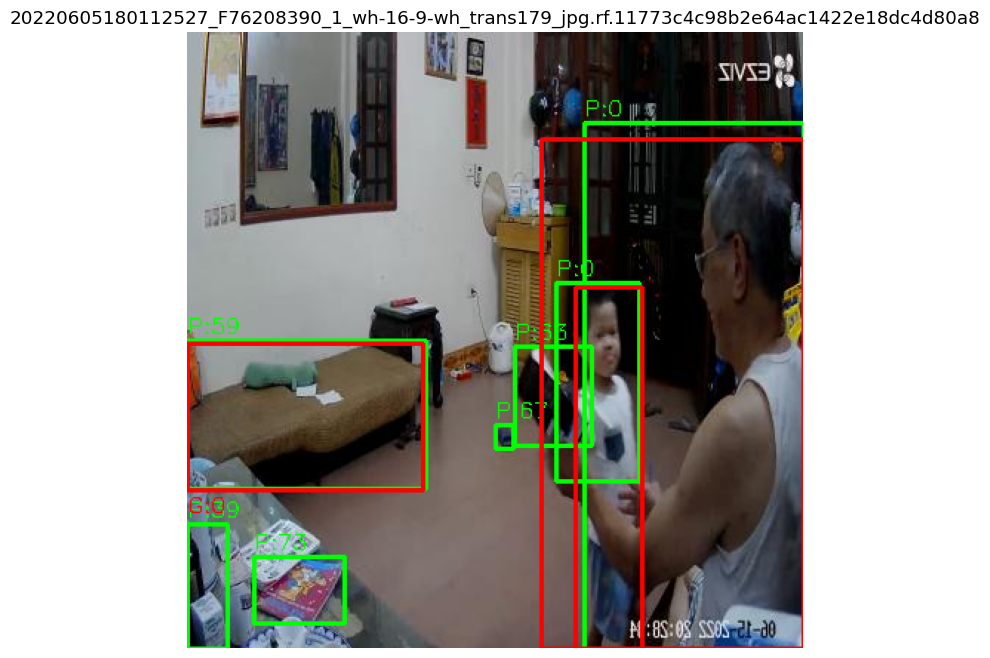

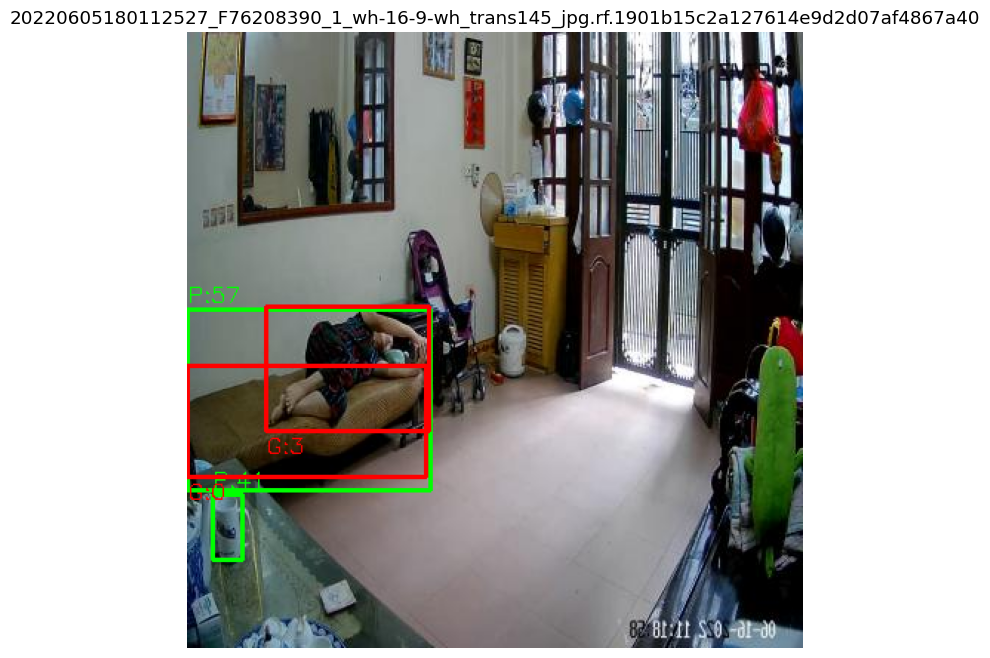

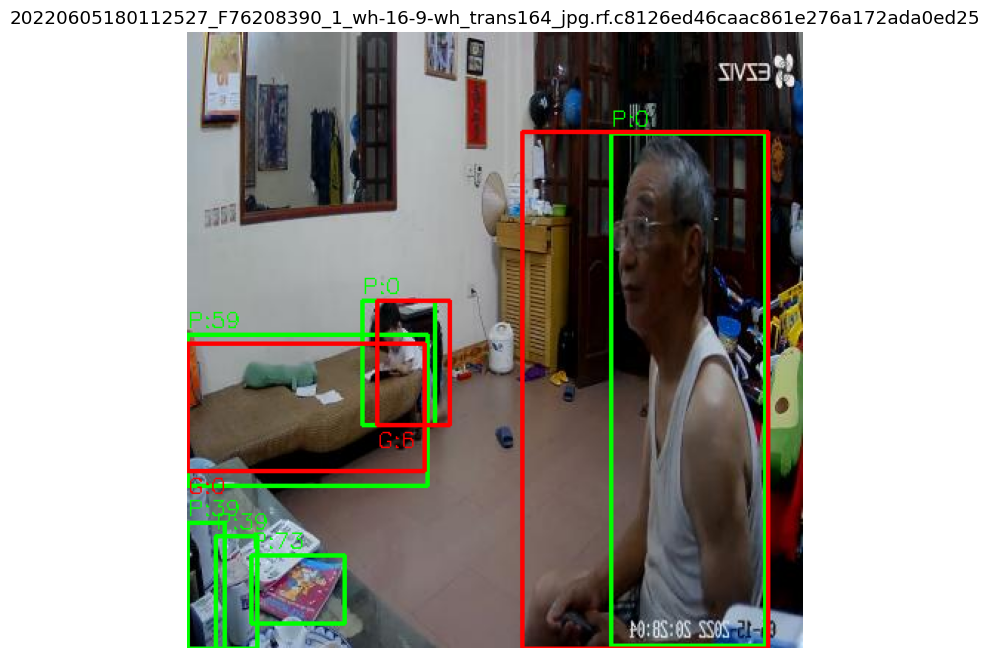

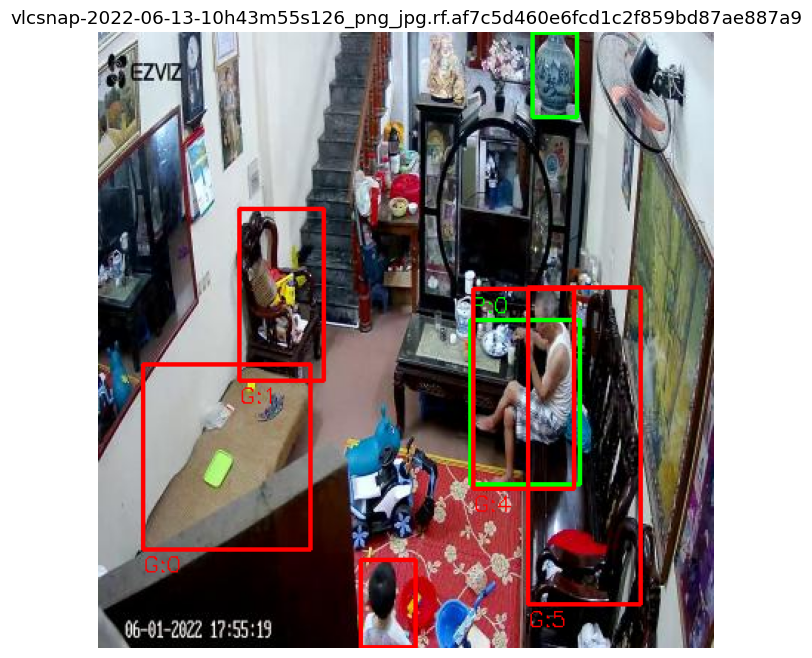

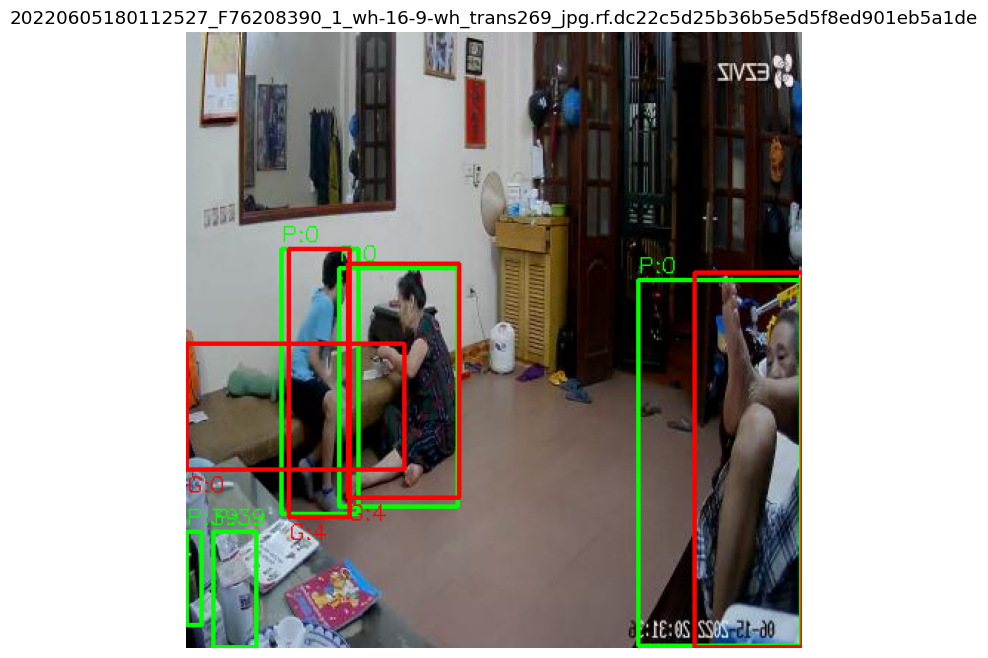

In [26]:
with open(OUTPUT_DIR / "detection_results.json", "r") as f:
    detection_data = json.load(f)

with open(OUTPUT_DIR / "ground_truths.json", "r") as f:
    gt_data = json.load(f)

def display_detected_image(image_path, preds, gts, title=""):
    img = np.array(Image.open(image_path).convert("RGB"))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for p in preds:
        x1, y1, x2, y2 = map(int, p['bbox'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"P:{p['class']}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    for g in gts:
        x1, y1, x2, y2 = map(int, g['bbox'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, f"G:{g['class']}", (x1, y2 + 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()
    #plt.close()

for img_name, preds in detection_data.items():

    img_file = Path("./data/train/images") / f"{img_name}.jpg"
    if img_file.exists():
        gts = gt_data.get(img_name, [])
        display_detected_image(img_file, preds, gts, title=img_name)

In [27]:
# !zip yolov5s.zip yolov5s.pt